# <center>CSC420 Project  <br><br> Homography using RANSAC<br> <br> Student Number: 1002572236 <br><br>Name: Danil Redko</center>


                                                                                           

Let's start by importing the needed libraries:

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import cv2
from scipy.spatial.distance import euclidean as euc
import random
from numpy.linalg import eig, svd, norm
from matplotlib.patches import ConnectionPatch



In [2]:
cover = cv2.imread('data/DVDcovers/the_incredibles.jpg')[:,:,::-1]
test = cv2.imread('data/test/image_05.jpeg')[:,:,::-1]

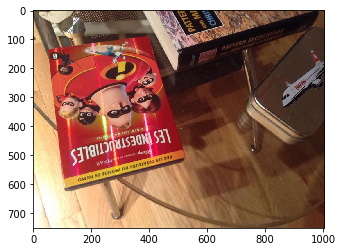

In [3]:
plt.imshow(test)
plt.show()

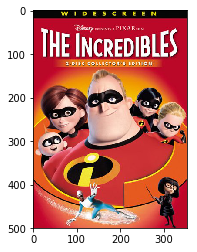

In [4]:
plt.imshow(cover)
plt.show()

Let's get the interesting points using SIFT algorithm. The code is taken from CSC420 Tutorial:

In [5]:
def get_interest_points(img):

    sift = cv2.xfeatures2d.SIFT_create()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kp, des = sift.detectAndCompute(gray, None)
    return kp, des

Now, in order to compute homography we need to find the matches. 

In [6]:
def matching(im1, im2):
    
    #REFERENCE FOR THE CODE https://www.learnopencv.com/image-alignment-feature-based-using-opencv-c-python/
    
    MAX_FEATURES = 500
    GOOD_MATCH_PERCENT = 0.15

    # Convert images to grayscale
    im1Gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    im2Gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

    # Detect ORB features and compute descriptors.
    orb = cv2.ORB_create(MAX_FEATURES)
    keypoints1, descriptors1 = orb.detectAndCompute(im1Gray, None)
    keypoints2, descriptors2 = orb.detectAndCompute(im2Gray, None)

    # Match features.
    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = matcher.match(descriptors1, descriptors2, None)

    # Sort matches by score
    matches.sort(key=lambda x: x.distance, reverse=False)

    # Remove not so good matches
    numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
    matches = matches[:numGoodMatches]

    # Extract location of good matches
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)

    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt


    points1 = np.array(points1)
    points2 = np.array(points2)

    matches = np.concatenate((points1, points2), axis=1)

    return matches, points1, points2

In [35]:
def match_images(img1, img2, matches):
    
    img1_show = img1.copy()
    img2_show = img2.copy()
    
    shape_img1 = img1.shape
    shape_img2 = img2.shape

    f=plt.figure(figsize=(100,200))
    
    ax1 = f.add_subplot(1, 2, 1)
    ax1.imshow(img1)
    ax1.set_zorder(1)
    ax2 = f.add_subplot(1, 2, 2)
    ax2.imshow(img2)
    #matches.shape[0]
    
    
    colors = []

    for i in range(matches.shape[0]):
        colors.append('#'+'%06X' % randint(0, 0xFFFFFF))
    
    for i in range(0, matches.shape[0]):
        x_i, y_i, x_j, y_j = matches[i]
        
        xy1 = (x_i,y_i)
        xy2 = (x_j,y_j)
        
        con = ConnectionPatch(xyA=xy1, xyB=xy2, coordsA='data', coordsB='data', axesA=ax1, axesB=ax2, color=colors[i], linewidth=10)
        ax1.add_artist(con)

        #ax1.plot(x_i, y_i, markersize=10, c='red')
        #ax2.plot(x_j ,y_j, markersize=10, c='red')

        #plt.scatter(x_i, y_i, linewidth=1)
        #plt.imshow(img1_show)
        #plt.imshow(img2_show)
        #plt.scatter(x_j, y_j,  linewidth=1)
    #plt.imshow(full_image)

    plt.show()
    

In [8]:
def plot_rect(p1,p2,p3,p4,color,linewidth=2):

    plt.plot((p1[0], p2[0]), (p1[1], p2[1]), c=color, linewidth=linewidth)
    plt.plot((p1[0], p3[0]), (p1[1], p3[1]), c=color, linewidth=linewidth)
    plt.plot((p2[0], p4[0]), (p2[1], p4[1]), c=color, linewidth=linewidth)
    plt.plot((p3[0], p4[0]), (p3[1], p4[1]), c=color, linewidth=linewidth)

def transform_image(img1, img2, H):
    
    img1x, img1y, _ = img1.shape
    
    p1 = match_point_homography(0, 0 , H)
    p2 = match_point_homography(0.0, img1x, H)
    p3 = match_point_homography(img1y, 0.0, H)
    p4 = match_point_homography(img1y, img1x, H)
    plt.imshow(img2)
    plot_rect(p1, p2, p3, p4, 'r')
    plt.show()

We need to compute the homography. 

# Ah = 0 <br>

where $A$ is $2n \times 9$ <br> <br>

$h$ is $9 \times 1$ <br><br>

So we have an equation in the following form : <br><br>

$\begin{bmatrix}
    x_{1} & y_{1} & 1 & 0 & 0 & 0 & -x^{'}_{1}x_{1} & -x^{'}_{1}y_{1} & -x^{'}_{1} \\
    0 & 0 & 0 & x_{1} & y_{1} & 1 & -y^{'}_{1}x_{1} & -y^{'}_{1}y_{1} & -y^{'}_{1} \\
       & & & & &\vdots \\
    x_{n} & y_{n} & 1 & 0 & 0 & 0 & -x^{'}_{n}x_{n} & -x^{'}_{n}y_{n} & -x^{'}_{n} \\
    0 & 0 & 0 & x_{n} & y_{n} & 1 & -y^{'}_{n}x_{n} & -y^{'}_{n}y_{n} & -y^{'}_{n}
\end{bmatrix}$ $\begin{bmatrix} h_{00} \\h_{01}\\h_{02}\\h_{10}\\h_{11}\\h_{12}\\h_{20}\\h_{21}\\h_{22} \end{bmatrix}$ =  $\begin{bmatrix} 0 \\ 0 \\ \vdots \\ 0 \\ 0 \end{bmatrix}$


*Note: 

<br>In the code below: 

$x_i$ corresponds to $x$ <br>

$x_j$ corresponds to $x^{'}$ <br>

Similarly, for y: 

$y_i$ corresponds to $y$ <br>

$y_j$ corresponds to $y^{'}$ <br>


In [9]:
def compute_homography(matches):

    #Create an array -  A

    A = []

    for i in range(0, matches.shape[0]):

        x_i, y_i, x_j, y_j = matches[i]

        row = [x_i, y_i, 1, 0, 0, 0, -x_j*x_i, -x_j*y_i, -x_j]

        A.append(row)
        
        row = [0, 0, 0, x_i, y_i, 1, -y_j*x_i, -y_j*y_i, -y_j]
        
        A.append(row)

    A = np.array(A)

    e_val, e_vec = eig(np.matmul(A.T, A))
   
    h = e_vec[:, np.argmin(e_val)].reshape(3, 3)

    return h
        
    '''
    Solution: h = eigenvector of A.T*A with smallest eigenvalue
    
    Eig returns the normalized (unit “length”) eigenvectors,
    such that the column e_vec[:,i] is the eigenvector corresponding to the eigenvalue e_val[i].
    '''
    

In [10]:
def match_point_homography(x, y, H):
    
    """
    point is a match of on the reference image
    
    H is a homography matrix (given by compute_homography function)
    
    returns a coordinates of the match on the test image
    
    """

    vector = np.array([x, y, 1])
    
    result = np.dot(H, vector) # Gets a vector of the form [ax', ay', a].T

    new_x, new_y , _ = result / result[-1]
    
    return new_x, new_y


In [11]:
def transform_image(img1, img2, H, color_of_line, line_width):
    
    img1x, img1y, _ = img1.shape
    
    p1 = match_point_homography(0, 0 , H)
    p2 = match_point_homography(0.0, img1x, H)
    p3 = match_point_homography(img1y, 0.0, H)
    p4 = match_point_homography(img1y, img1x, H)
    plt.imshow(img2)
    plot_rect(p1, p2, p3, p4, color_of_line, line_width)
    plt.show()   

In [12]:
def RANSAC(matches):

    best_inliers = 0
    
    best_H  = None
    
    for i in range(0, 1000):
                                
        SampleMatches = np.array(random.sample(matches, 4))
        
        H = compute_homography(SampleMatches)
        
        inliers = 0 

        for match in matches:

            x_i, y_i, x_j, y_j = match

            new_x, new_y = match_point_homography(x_i, y_i, H)

            dist = norm(np.array([x_j - new_x, y_j - new_y]))

            if dist < 3:

                inliers += 1

        if inliers > best_inliers:
            
            best_inliers = inliers 

            best_H = H

    return best_H, best_inliers

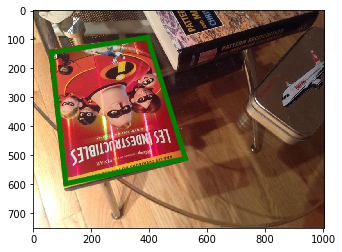

The number of inliers: 38


In [13]:
matches, points1, points2 = matching(cover, test)
myH, number_of_inliers = RANSAC(matches)
transform_image(cover, test, myH, 'green', 5)
print('The number of inliers: {}'.format(number_of_inliers))

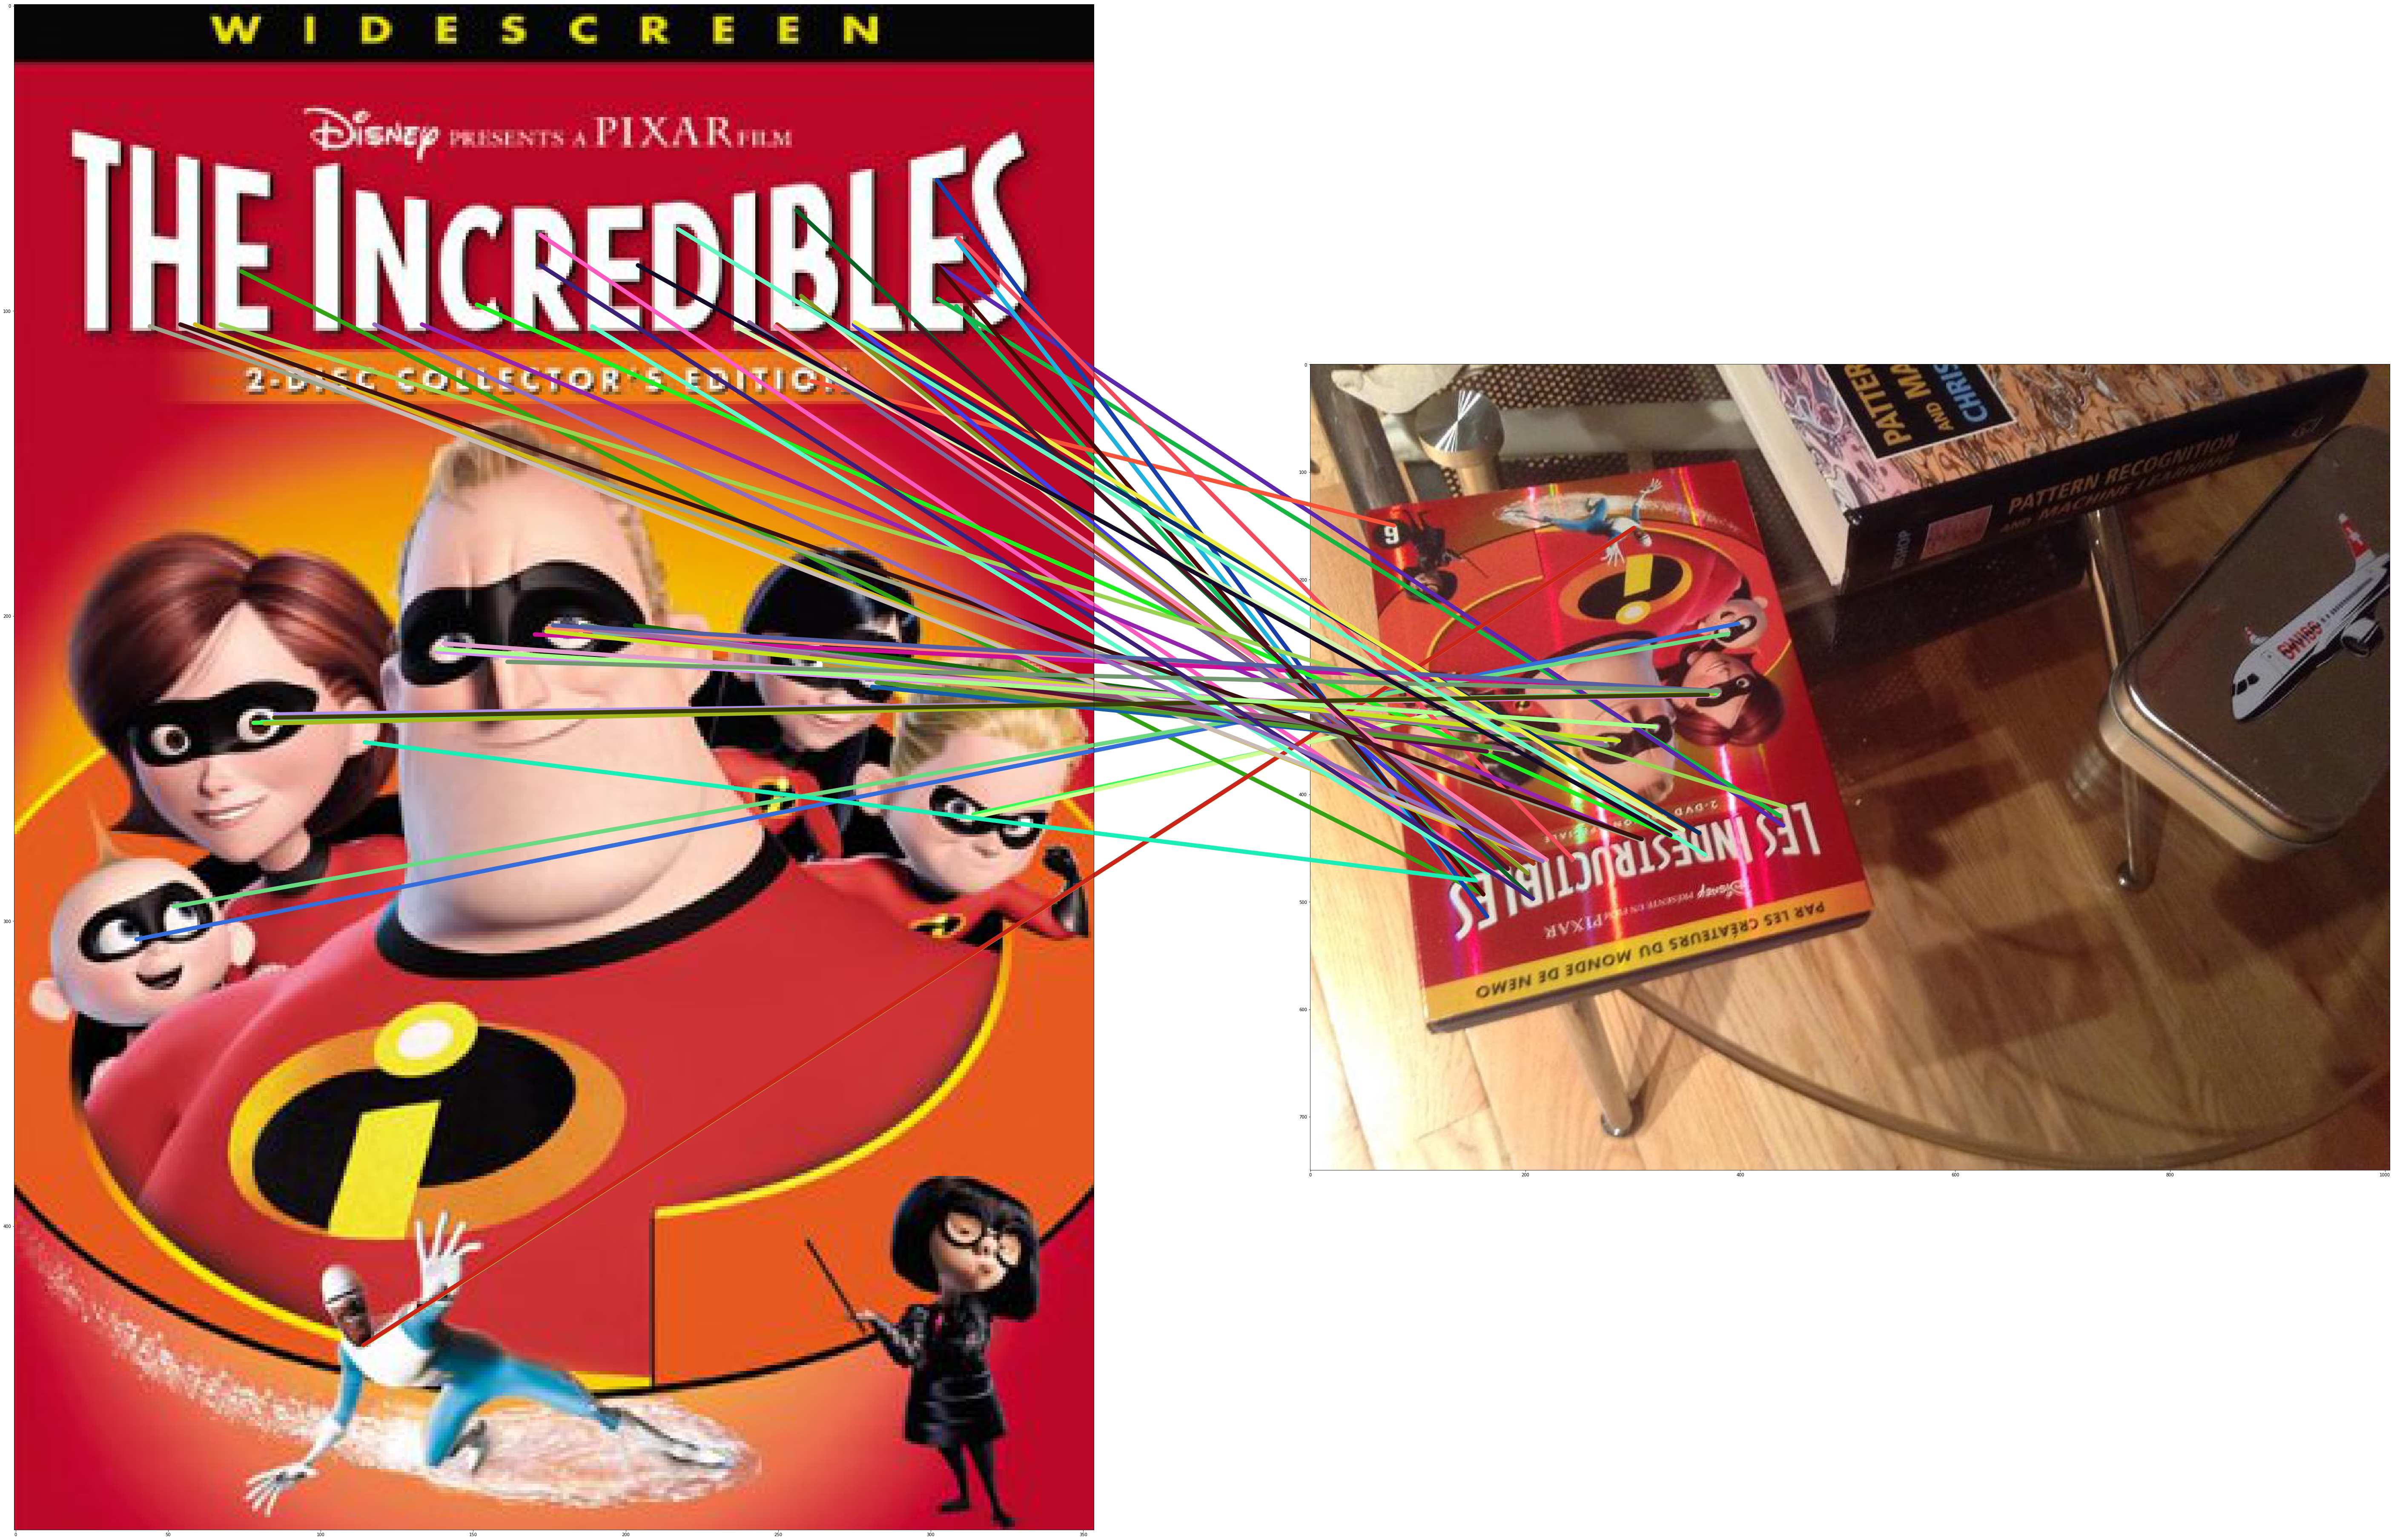

In [36]:
match_images(cover, test, matches)

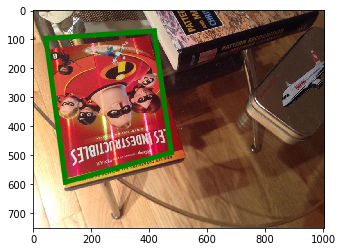

In [15]:
h, _ = cv2.findHomography(points1, points2, cv2.RANSAC)
transform_image(cover, test, h, 'green', 5)